# Comparison To Historical Data

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a historical 3 day period.

In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [2]:
# write csv files for import
start = '2018-01-01 00:00:00'
end = '2018-12-31 23:00:00'
# year of simulation
year = 2018
# time step as fraction of hour
time_step = 1

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [3]:
data_reader_writer.data_writer(start, end, time_step, year, merge_generators=True)

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [4]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [5]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

LOPF does not account for losses through lines. Here we add a 10% margin to the load in order to account for these losses.

In [6]:
network.loads_t.p_set.iloc[:, 0:29] *= 1.1

## Running the optimisation

In [7]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 126.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-03
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-v4xz918u.lp
Reading time = 73.15 seconds
obj: 27855382 rows, 7235761 columns, 49245880 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 27855382 rows, 7235761 columns and 49245880 nonzeros
Model fingerprint: 0xbf5cf689
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 26795438 rows and 43801 columns (presolve time = 19s) ...
Presolve removed 26795438 rows and 231476 columns (presolve time = 21s) ...
Presolve removed 26795438 rows and 231476 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.59e+09


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [8]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

%store p_by_carrier
p_by_carrier

Stored 'p_by_carrier' (DataFrame)


carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Tidal Barrage and Tidal Stream,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,315.200000,0.00,19.929,531.542604,396.576,3163.499962,743.5,312.435669,8408.289321,6833.530000,0.0,50.2,24.0,40.564332,0.0,8.0,5322.763752,6499.869773,0.000000,1128.829000
2018-01-01 01:00:00,315.200000,0.00,0.000,0.000000,396.576,2756.500024,743.5,308.010233,9723.029280,6833.530000,0.0,50.2,24.0,39.989766,0.0,8.0,5318.656864,6233.178739,24.029040,1108.900000
2018-01-01 02:00:00,315.200000,0.00,0.000,0.000000,396.576,2771.499986,743.5,293.406300,10007.058937,6833.530000,0.0,50.2,24.0,38.093700,0.0,8.0,5315.245105,6067.016448,67.273469,1108.900000
2018-01-01 03:00:00,315.200000,0.00,0.000,0.000000,396.576,2626.499986,743.5,247.824325,9154.443621,6833.530000,0.0,50.2,24.0,32.175674,0.0,8.0,5312.001825,5988.198334,0.000000,1108.900000
2018-01-01 04:00:00,315.200000,0.00,0.000,0.000000,396.576,2625.499957,743.5,240.743629,8229.633167,6833.530000,0.0,50.2,24.0,31.256368,0.0,8.0,5306.942938,5794.067603,0.000000,1108.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,311.700000,509.54,2272.563,1961.000000,396.576,3055.999925,734.8,228.226867,15647.362909,6270.701406,0.0,50.2,23.0,29.925967,0.0,0.0,4056.750335,7740.773294,543.480018,3878.803000
2018-12-31 20:00:00,303.500000,509.54,2272.563,1961.000000,396.576,2717.000034,708.7,166.189638,13223.028345,6238.481406,0.0,50.2,23.0,22.203657,0.0,0.0,4415.811929,7742.706223,0.000000,3844.503000
2018-12-31 21:00:00,303.500000,509.54,2272.563,1961.000000,396.576,2714.000037,708.7,163.239527,9875.306770,6206.261406,0.0,50.2,23.0,21.809509,0.0,0.0,4823.838473,7626.915196,0.000000,3844.503000


Graph the power output of the different generation types...

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

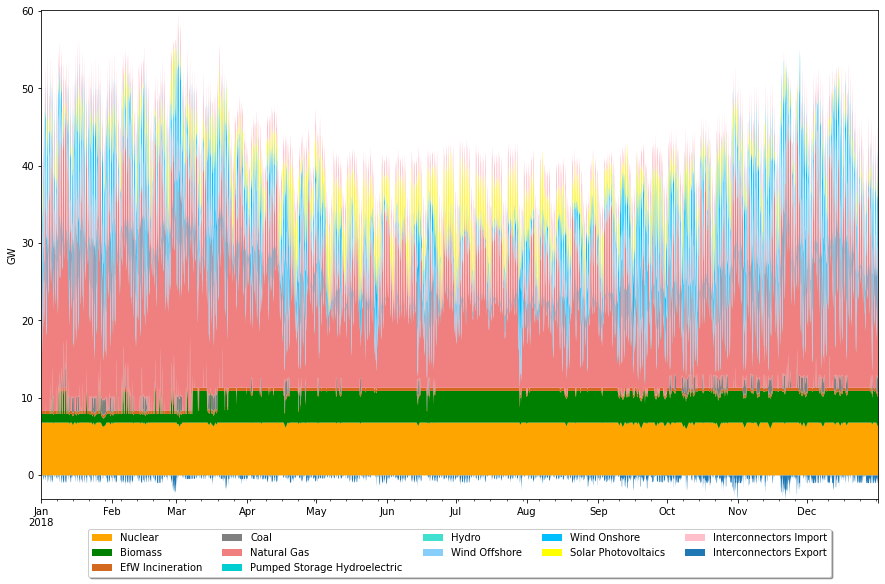

In [9]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Simulated vs historical data power generation

We can group the generators by type and sum to calculate the total simulated power generation over the year in TWh.

In [10]:
%store -r p_by_carrier

p_by_carrier = p_by_carrier.sum() / 1000000
# print(p_by_carrier)
p_by_carrier['Hydro'] = p_by_carrier['Small Hydro'] + p_by_carrier['Hydro']
p_by_carrier['Oil'] = 0.
p_by_carrier.drop(['Small Hydro', 'Anaerobic Digestion', 'Biomass (co-firing)', 'Biomass (dedicated)', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream'], inplace=True)
p_by_carrier

carrier
Coal                              3.041580
EfW Incineration                  3.474006
Interconnectors Import           21.929185
Hydro                             2.988822
Natural Gas                     139.369596
Nuclear                          59.480659
Oil                               0.000000
Solar Photovoltaics              14.709476
Wind Offshore                    26.039234
Wind Onshore                     29.114726
Pumped Storage Hydroelectric      0.444488
Biomass                          30.997990
dtype: float64

Then the total of all simulated power generation is:

In [11]:
p_by_carrier.sum()

331.5897624571445

BEIS publish reports on power generation, and here we extract the data for 2018 from X  and Y https://www.gov.uk/government/statistics/energy-trends-section-6-renewables

In [12]:
data = {'Coal': 16.0,
        'EfW Incineration': 3.5,
        'Interconnectors Import': 21.9,
        'Hydro': 5.4,
        'Natural Gas': 129.1,
        'Nuclear': 59.1,
        'Oil': 1.0,
        'Solar Photovoltaics': 12.7,
        'Wind Offshore': 26.5,
        'Wind Onshore': 30.4,
        'Pumped Storage Hydroelectric': 0.0,
        'Biomass': 31.5
        }
data_series = pd.Series(data)
data_series

Coal                             16.0
EfW Incineration                  3.5
Interconnectors Import           21.9
Hydro                             5.4
Natural Gas                     129.1
Nuclear                          59.1
Oil                               1.0
Solar Photovoltaics              12.7
Wind Offshore                    26.5
Wind Onshore                     30.4
Pumped Storage Hydroelectric      0.0
Biomass                          31.5
dtype: float64

In [13]:
data_series.sum()

337.09999999999997

In [14]:
data_series.index

Index(['Coal', 'EfW Incineration', 'Interconnectors Import', 'Hydro',
       'Natural Gas', 'Nuclear', 'Oil', 'Solar Photovoltaics', 'Wind Offshore',
       'Wind Onshore', 'Pumped Storage Hydroelectric', 'Biomass'],
      dtype='object')

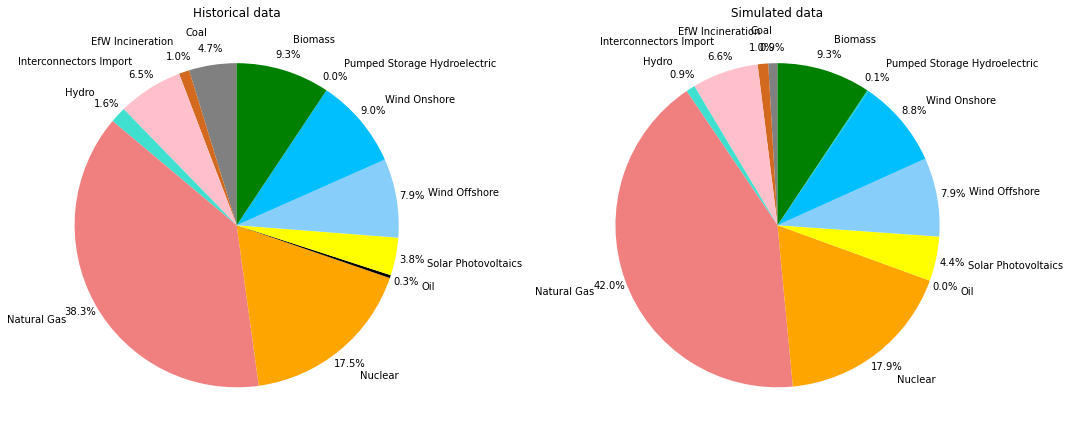

In [15]:
# mylabels = data_series.index
# mycolors = categorical_cmap(3, 10)

colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,15)

ax1.pie(data_series, labels=data_series.index,
        colors=[colors[col] for col in p_by_carrier.index], autopct="%1.1f%%",
        startangle=90, pctdistance=1.1, labeldistance=1.2)
ax1.set_title('Historical data')

simulated_generation = p_by_carrier
ax2.pie(simulated_generation, labels=simulated_generation.index,
        colors=[colors[col] for col in p_by_carrier.index], autopct="%1.1f%%",
        startangle=90, pctdistance=1.1, labeldistance=1.2)
ax2.set_title('Simulated data')

plt.tight_layout()

In [16]:
df = pd.DataFrame([simulated_generation, data_series], index=['Simulated', 'Historical']).T.round(1)
df.fillna(0, inplace=True)
df['Simulated - Historical'] = df['Simulated'] - df['Historical']
df['Simulated (%)'] = (df['Simulated'] / df['Simulated'].sum()* 100).round(1)
df['Historical (%)'] = (df['Historical'] / df['Historical'].sum()* 100).round(1)
df['Simulated (%) - Historical (%)'] = df['Simulated (%)'] - df['Historical (%)']
df.loc["Total"] = df.sum().round(2)
df

,Simulated,Historical,Simulated - Historical,Simulated (%),Historical (%),Simulated (%) - Historical (%)
Coal,3.0,16.0,-13.0,0.9,4.7,-3.8
EfW Incineration,3.5,3.5,0.0,1.1,1.0,0.1
Interconnectors Import,21.9,21.9,0.0,6.6,6.5,0.1
Hydro,3.0,5.4,-2.4,0.9,1.6,-0.7
Natural Gas,139.4,129.1,10.3,42.1,38.3,3.8
Nuclear,59.5,59.1,0.4,17.9,17.5,0.4
Oil,0.0,1.0,-1.0,0.0,0.3,-0.3
Solar Photovoltaics,14.7,12.7,2.0,4.4,3.8,0.6
Wind Offshore,26.0,26.5,-0.5,7.8,7.9,-0.1
Wind Onshore,29.1,30.4,-1.3,8.8,9.0,-0.2


Looking at table above we can see
- Gas too high
- Coal too low

Likely due to price dynamics of gas and coal which are not fully captured in marginal cost. 